In [1]:
import sys 
import numpy as np # linear algebra
from scipy.stats import randint
import matplotlib.pyplot as plt # this is used for the plot the graph 
%matplotlib inline
from tqdm import notebook
import tensorflow as tf
from scipy import stats
from scipy.interpolate import interp1d

### Load data

In [2]:
train=np.load('Train.npy')
test=np.load('Test.npy')

train_x=train[:,:-1]
train_y=train[:,-1].reshape(-1,1)

test_x=test[:,:-1]
test_y=test[:,-1].reshape(-1,1)

ntrain=len(train_x)
ntest=len(test_x)


In [3]:
stats.describe(train_y),stats.describe(test_y)

(DescribeResult(nobs=125, minmax=(array([-0.58152491]), array([5.58975983])), mean=array([-1.11022302e-17]), variance=array([1.00806452]), skewness=array([3.77288201]), kurtosis=array([16.14205386])),
 DescribeResult(nobs=84, minmax=(array([-0.58152491]), array([2.13729284])), mean=array([-0.10976482]), variance=array([0.37303389]), skewness=array([2.2176584]), kurtosis=array([4.50208885])))

### Collaborating Network(CN)

In [4]:
def variables_from_scope(scope_name):
    """
    Returns a list of all trainable variables in a given scope. This is useful when
    you'd like to back-propagate only to weights in one part of the network
    (in our case, the generator or the discriminator).
    """
    return tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.TRAINABLE_VARIABLES, scope=scope_name)

In [5]:
 # Graph parameters
intermediate_layer_size = 100
intermediate_layer_size2 = 80
intermediate_layer_size3 = 60
# Training parameters
batch_size = 100
pre_iter= ntrain*40
iter= ntrain*60

In [6]:
# f function learn the inverse of cdf
def f(x,q):
    """x:input feature and treatment,
    q:percentile,
    """
    z0=tf.concat([x,q],axis=1)
    hidden_layer = tf.compat.v1.layers.dense(z0, intermediate_layer_size, kernel_initializer=tf.keras.initializers.RandomNormal(stddev=.001),name="f1", activation=tf.compat.v1.nn.elu,reuse=None)
    hidden_layer_bn = tf.compat.v1.layers.batch_normalization(hidden_layer,name="f1bn")
    hidden_layer2 = tf.compat.v1.layers.dense(hidden_layer_bn, intermediate_layer_size2, kernel_initializer=tf.keras.initializers.RandomNormal(stddev=.001),name="f2", activation=tf.keras.activations.elu,reuse=None)
    hidden_layer2_bn = tf.compat.v1.layers.batch_normalization(hidden_layer2,name="f2bn")
    hidden_layer3 = tf.compat.v1.layers.dense(hidden_layer2_bn, intermediate_layer_size3, kernel_initializer=tf.keras.initializers.RandomNormal(stddev=.001),name="f3", activation=tf.compat.v1.nn.elu,reuse=None)
    hidden_layer3_bn = tf.compat.v1.layers.batch_normalization(hidden_layer2,name="f3bn")
    yq = tf.compat.v1.layers.dense(hidden_layer3_bn,1,kernel_initializer=tf.keras.initializers.RandomNormal(stddev=.001), name="f4", activation=None,reuse=None)
    return yq

In [7]:
# g function learn the cdf
def g(yq,x):
    """
    yq:quantile:,
    x:input feature and treatment,
    """
    z1=tf.concat([yq,x],axis=1)
    hidden_layer = tf.compat.v1.layers.dense(z1, intermediate_layer_size,kernel_initializer=tf.compat.v1.initializers.random_normal(stddev=.001), name="g1", activation=tf.compat.v1.nn.elu,reuse=None)
    hidden_layer_bn = tf.compat.v1.layers.batch_normalization(hidden_layer,name="g1bn")
    hidden_layer2 = tf.compat.v1.layers.dense(hidden_layer_bn, intermediate_layer_size2, kernel_initializer=tf.compat.v1.initializers.random_normal(stddev=.001),name="g2", activation=tf.compat.v1.nn.elu,reuse=None)
    hidden_layer2_bn = tf.compat.v1.layers.batch_normalization(hidden_layer2,name="g2bn")
    gq_logit = tf.compat.v1.layers.dense(hidden_layer2_bn, 1,kernel_initializer=tf.initializers.glorot_normal, name="g3", activation=None,reuse=None)
    gq_logit_bn=tf.keras.layers.BatchNormalization(axis=-1,momentum=.1)(gq_logit)*tf.math.sqrt(3.29) #,trainable=False
    return gq_logit_bn

In [8]:
tf.compat.v1.disable_eager_execution()

In [9]:

tf.compat.v1.reset_default_graph()

# Placeholders
y_ = tf.compat.v1.placeholder(tf.float32, [None, 1])

pre_y= tf.compat.v1.placeholder(tf.float32, [None, 1])
x_=tf.compat.v1.placeholder(tf.float32, [None, train_x.shape[1]])
q_ = tf.compat.v1.placeholder(tf.float32, [None, 1])


# f
with tf.compat.v1.variable_scope("f") as scope:
    yq_= f(x_,q_)


ylessthan= tf.cast(tf.less_equal(y_,yq_),tf.float32)
ylessthan_pre= tf.cast(tf.less_equal(y_,pre_y),tf.float32)


with tf.compat.v1.variable_scope("g") as scope:
    gq_logit = g(yq_,x_)
    gq=tf.sigmoid(gq_logit)*.99999+.00001
    scope.reuse_variables()
    gq_logit_pre = g(pre_y,x_)


#Losses
f_loss = tf.reduce_mean(tf.square(q_-gq))
g_loss = 1*tf.compat.v1.losses.sigmoid_cross_entropy(ylessthan,gq_logit)
# +\    .05*tf.compat.v1.losses.mean_squared_error(q_,gq)

#pre-loss
g_loss_pre = tf.compat.v1.losses.sigmoid_cross_entropy(ylessthan_pre,gq_logit_pre)

# Optimizer
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=1e-4)
pre_step= optimizer.minimize(g_loss_pre,var_list=variables_from_scope("g"))
g_step = optimizer.minimize(g_loss, var_list=variables_from_scope("g"))
f_step = optimizer.minimize(f_loss, var_list=variables_from_scope("f"))

# Initializer
initialize_all = tf.compat.v1.global_variables_initializer()

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).


### Training

In [30]:
sess = tf.compat.v1.Session()
sess.run(initialize_all)
gl=[]
fl=[]


for k in notebook.tnrange(pre_iter):
    i=np.random.randint(0,ntrain,batch_size)
    ytmp = train_y[i,:]
    xtmp= train_x[i,:]
    #when we do not have f initially, we use a uniform distribution to extract points from support
    pre_ytmp=np.random.uniform(-1,7,(batch_size,1))  
    sess.run(pre_step,feed_dict={y_: ytmp,
                                x_:xtmp,
                                pre_y:pre_ytmp})
    

for t in notebook.tnrange(iter):
    #randomly generate a minibatch from valid set
    i=np.random.randint(0,ntrain,([batch_size]))
    qtmp=np.random.uniform(0, 1.0, [batch_size, 1])
    ytmp = train_y[i,:]
    xtmp= train_x[i,:]
    
    for i in range(0,1):
        _,glt=sess.run([g_step,g_loss], feed_dict={y_: ytmp,
                                x_:xtmp,
                                q_:qtmp})
    gl.append(glt)
    
    for i in range(0,2):
        _,flt=sess.run([f_step,f_loss],feed_dict={y_: ytmp,
                                x_:xtmp,
                                q_:qtmp})
    fl.append(flt)

    

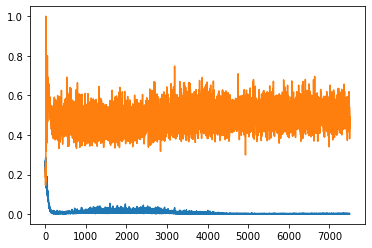

In [31]:
plt.plot(fl)
plt.plot(gl)

### Estimate calibration and likelihood

In [32]:
per=np.linspace(0.02,0.98,8)

In [33]:
low=np.quantile(test_y,0.05)
high=np.quantile(test_y,0.95)
itv=np.linspace(low,high,9)
itv=np.append(-np.infty,itv)
itv=np.append(itv,np.infty)
#outcome1 belongs to which interval
id=np.zeros(ntest)
for i in range(10):
    id=id+1*(test_y.ravel()>itv[i+1])
id=id.astype('int')


In [34]:
# estimation by g
med_est=np.array([]) #median
ll_est=np.empty(ntest) #negative log likelihood
cal_est=np.zeros_like(per) #calibration
widthg=[]  #interval width


# estimation by f
fmed_est=np.array([])  #median
fll_est=np.empty(ntest) #negative log likelihood
fcal_est=np.zeros_like(per) #calibration
widthf=[]  #interval width

#use interpolation to recover cdf
xtmp=np.linspace(-1,7,5000)
ptmp=np.linspace(0.001,0.999,5000)
ptmp1=np.append([0],ptmp)
ptmp1=np.append(ptmp1,[1])

for i in notebook.trange(ntest):

    #cdf estimate by g
    cdf=sess.run(gq ,feed_dict={x_:np.tile(test_x[i,:],(5000,1)),
                                yq_:xtmp[:,None]
                                }).ravel()

    invcdfest=interp1d(cdf,xtmp)
    cdfest=interp1d(xtmp,cdf)

    ##cdf estimate by f
    ficdf= sess.run(yq_ ,feed_dict={x_:np.tile(test_x[i,:],(5000,1)),
                                q_:ptmp[:,None]
                                }).ravel()    
    ficdf=np.append([-1],ficdf)
    ficdf=np.append(ficdf,7)

    finvcdfest=interp1d(ptmp1,ficdf)
    fcdfest=interp1d(ficdf,ptmp1)
      
    #estimate the ite
    med_est=np.append(med_est,invcdfest(0.5))    
    fmed_est=np.append(fmed_est,finvcdfest(0.5))   
    #estimate the loglikelihood
    l=itv[id[i]]
    r=itv[id[i]+1]


    if(r==np.inf):
        ll_est[i]=np.log(1.-cdfest(l)+1.e-10)
        fll_est[i]=np.log(1.-fcdfest(l)+1.e-10)
    elif(l==-np.inf):
        ll_est[i]=np.log(cdfest(r)+1.e-10)
        fll_est[i]=np.log(fcdfest(r)+1.e-10)
    else:
        ll_est[i]=np.log(cdfest(r)-cdfest(l)+1.e-10)
        fll_est[i]=np.log(fcdfest(r)-fcdfest(l)+1.e-10)

    
    #estimate the calibration
    gl=invcdfest(0.5-per/2)
    gr=invcdfest(0.5+per/2)
    cal_est=cal_est+1.*(test_y[i]<gr)*(test_y[i]>gl)

    fl=finvcdfest(0.5-per/2)
    fr=finvcdfest(0.5+per/2)
    fcal_est=fcal_est+1.*(test_y[i]<fr)*(test_y[i]>fl)

    widthg.append(gr-gl)
    widthf.append(fr-fl)


cal_est=cal_est/ntest
fcal_est=fcal_est/ntest

In [35]:
cal_est,fcal_est

(array([0.        , 0.13095238, 0.29761905, 0.41666667, 0.54761905,
        0.73809524, 0.85714286, 0.96428571]),
 array([0.        , 0.20238095, 0.39285714, 0.5       , 0.6547619 ,
        0.75      , 0.80952381, 0.88095238]))

In [37]:
np.abs(cal_est-per).mean(),np.abs(fcal_est-per).mean()

(0.01845238095238093, 0.0619047619047619)

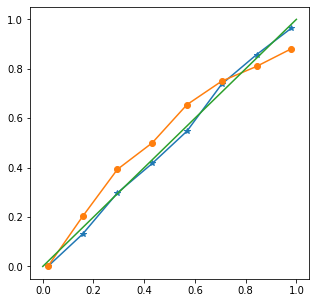

In [41]:
## calibration plot
plt.figure(figsize=(5,5))
plt.plot(per,cal_est,'-*')
plt.plot(per,fcal_est,'-o')

plt.plot([0,1],[0,1])

In [38]:
## negative ll
ll_est.mean(),fll_est.mean()

(-1.0910509053305435, -1.221690552448508)

In [39]:
## mae
np.abs(test_y.ravel()-med_est).mean(),np.abs(test_y.ravel()-fmed_est).mean()

(0.12432537367167998, 0.12198288993093452)

In [45]:
# interval width
widthg=np.array(widthg)
widthf=np.array(widthf)

wg_med=np.median(widthg,0)
wf_med=np.median(widthf,0)

In [47]:
wg_med,wf_med

(array([0.00443193, 0.0351078 , 0.06721726, 0.10239887, 0.14328576,
        0.19519281, 0.27407816, 0.51775068]),
 array([0.00628538, 0.04939205, 0.09252729, 0.13571721, 0.17899049,
        0.22237538, 0.26590566, 0.30961764]))

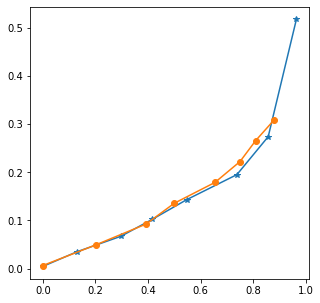

In [54]:
### sharpness plot
plt.figure(figsize=(5,5))
plt.plot(cal_est,wg_med,'-*')
plt.plot(fcal_est,wf_med,'-o')



#### 90% interval width and coverage

In [53]:
width_est=np.empty(ntest)
cover_90=0

fwidth_est=np.empty(ntest)
fcover_90=0

#use interpolation to recover cdf
xtmp=np.linspace(-1,7,5000)
ptmp=np.linspace(0,1,5000)

for i in notebook.trange(ntest):
    #cdf estimate
    cdf=sess.run(gq ,feed_dict={x_:np.tile(test_x[i,:],(5000,1)),
                                yq_:xtmp[:,None]
                                }).ravel()
    
     

    invcdfest=interp1d(cdf,xtmp)
    r=invcdfest(0.95)
    l=invcdfest(0.05)
    cover_90+=(test_y[i]<r)*(test_y[i]>l)
    width_est[i]=invcdfest(0.95)-invcdfest(0.05)

    ##cdf estimate by f
    ficdf= sess.run(yq_ ,feed_dict={x_:np.tile(test_x[i,:],(5000,1)),
                                q_:ptmp[:,None]
                                }).ravel()  
    finvcdfest=interp1d(ptmp,ficdf)
    fr=finvcdfest(0.95)
    fl=finvcdfest(0.05)
    fcover_90+=(test_y[i]<fr)*(test_y[i]>fl)
    fwidth_est[i]=finvcdfest(0.95)-finvcdfest(0.05)    



print(cover_90/ntest,fcover_90/ntest)


[0.9047619] [0.8452381]
